##  Import Libraries

In [1]:
#!pip install selenium
#!pip install tweepy
#!pip install wordcloud

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilhamalami/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ilhamalami/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ilhamalami/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ilhamalami/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/ilhamalami/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ilhamalami/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     

##  Tweets & Sentiments
###  Getting Tweets
there are two methods to fetch tweets from Tweeter:<br/>
__Using Selenium <br/>__
__Using tweepy <br/>__

The following are two classes and we can use only ine of them.
Note: Selenium is very slow comparing with tweepy and the chrome webdriver localisation is necessary . 


In [3]:
class SeleniumClient(object):
    def __init__(self):
        #Initialization. 
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--disable-setuid-sandbox')

        #Path of chromdriver in your machine
        self.browser = webdriver.Chrome('D:/chromedriver_win32/chromedriver', options=self.chrome_options)

        self.base_url = 'https://twitter.com/search?q='

    def get_tweets(self, query):
        #getting tweets function. 
        try: 
            self.browser.get(self.base_url+query)
            time.sleep(2)

            body = self.browser.find_element_by_tag_name('body')

            for _ in range(3000):
                body.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)

            timeline = self.browser.find_element_by_id('timeline')
            tweet_nodes = timeline.find_elements_by_css_selector('.tweet-text')

            return pd.DataFrame({'tweets': [tweet_node.text for tweet_node in tweet_nodes]})

        except:
            print("Selenium - An error occured while fetching tweets.")

In [4]:
# your Twitter Dev Credentials
consumer_key = 'Sec3MvclRIx2RVlgu9l0SJX6D'
consumer_secret = 'ayoPNWtBm7fWpMBoK6EwRmegu3SW8Rw9mzJkottkv97quPe941'
access_token = '736550752760406018-so5CPJrEbJKb3c3Pq8va3VFr0yk4S0E'
access_token_secret = 'Cgr8tz0h6FTU7kxAjDzpHnjffNTHxWsBytXnu4Ihd1TFb'

In [5]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization. 
        try: 
            #OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            #token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            #tweepy API object to fetch tweets 
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #getting tweets function.  
        tweets = [] # empty list to store parsed tweets
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

####  Using Selenium
We could not use 'request' and 'BeautifuSoup' because in case of twitter tweet-feed comes dynamically (from JavaScript) in a progressively manner (infinite load). So we are using Selenium, it can mock the browser behaviour.

In [6]:
# selenium_client = SeleniumClient()

# # calling function to get tweets
# tweets_df = selenium_client.get_tweets('AI and Deep learning')
# print(f'tweets_df Shape - {tweets_df.shape}')
# tweets_df.head(10)

####  Using 'tweepy'

In [7]:
twitter_client = TwitterClient()

# calling getting tweets function
tweets_df = twitter_client.get_tweets('AI and Deep learning', maxTweets=7000)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1100 tweets
Downloaded 1200 tweets
Downloaded 1300 tweets
Downloaded 1400 tweets
Downloaded 1500 tweets
Downloaded 1600 tweets
Downloaded 1700 tweets
Downloaded 1800 tweets
Downloaded 1900 tweets
Downloaded 2000 tweets
Downloaded 2100 tweets
Downloaded 2200 tweets
Downloaded 2300 tweets
Downloaded 2400 tweets
Downloaded 2500 tweets
Downloaded 2600 tweets
Downloaded 2700 tweets
Downloaded 2800 tweets
Downloaded 2900 tweets
Downloaded 3000 tweets
Downloaded 3100 tweets
Downloaded 3200 tweets
Downloaded 3300 tweets
Downloaded 3400 tweets
Downloaded 3500 tweets
Downloaded 3552 tweets
No more tweets found
tweets_df Shape - (1658, 1)


,tweets
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...
1,"RT @benedictevans: With most new tech, the peo..."
2,@StableVoices @realDonaldTrump Hi @StableVoice...
3,RT @IntelIndia: Scale #AI beyond the lab and i...
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...
5,RT @MSFTResearch: Data-driven algorithm design...
6,RT @antgrasso: Supervised algorithms use label...
7,RT @DirkSchaar: Supervised algorithms use labe...
8,"""These new directions include tighter integrat..."
9,RT @gp_pulipaka: #Hadoop 3.2.0 released with #...


###  Getting sentiments
the tweet fetched from Twitter are not labeled, and in order to apply classification models we need to have labeled data. Foresure, it is not feasible to label the tweets manually.


In order to know the sentiment type of every tweet, there are two ways: <br/>
    __a. Using NLTK's SentimentIntensityAnalyzer (We'll refer as SIA)<br/>__
    __b. Using TextBlob<br/>__

In [8]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

####  Using NLTK's SentimentIntensityAnalyzer

In [9]:
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,1535
neg,123


#### Using TextBlob

In [10]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,1332
neg,326


TextBlob gives us more negative sentiments than SIA, so we will prefer textblob, since classfication seems better.

In [11]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

,tweets,sentiment
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg
1,"RT @benedictevans: With most new tech, the peo...",pos
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos


##  Text Pre-processing
### A. Pre-processing 'Key Words'
#### a. Removing '@names'
Here we can see that at many places we have '@names', which is of no use, since it don't have any meaning, So needs to be removed.

In [12]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [13]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg,#ai Deep Learning Pioneer Yoshua Bengio Says A...
1,"RT @benedictevans: With most new tech, the peo...",pos,"With most new tech, the people closest to it ..."
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos,@StableVoices @realDonaldTrump Hi @StableVoice...
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos,Scale #AI beyond the lab and into the real wo...
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos,ead about N-Grams https://t.co/SbuvhivIn0 #Pro...
5,RT @MSFTResearch: Data-driven algorithm design...,pos,"Data-driven algorithm design, reducing ML bia..."
6,RT @antgrasso: Supervised algorithms use label...,pos,Supervised algorithms use labeled data in whi...
7,RT @DirkSchaar: Supervised algorithms use labe...,pos,Supervised algorithms use labeled data in whi...
8,"""These new directions include tighter integrat...",pos,"""These new directions include tighter integrat..."
9,RT @gp_pulipaka: #Hadoop 3.2.0 released with #...,pos,"#Hadoop 3.2.0 released with #YAN, Hadoop Subm..."


Seems good, now we don't have '@name' values

#### id='3Ab'>b. Removing links (http | https)

In [14]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg,#ai Deep Learning Pioneer Yoshua Bengio Says A...
1,"RT @benedictevans: With most new tech, the peo...",pos,"With most new tech, the people closest to it a..."
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos,@StableVoices @realDonaldTrump Hi @StableVoice...
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos,Scale #AI beyond the lab and into the real wor...
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos,ead about N-Grams #Probability #NGrams
5,RT @MSFTResearch: Data-driven algorithm design...,pos,"Data-driven algorithm design, reducing ML bias..."
6,RT @antgrasso: Supervised algorithms use label...,pos,Supervised algorithms use labeled data in whic...
7,RT @DirkSchaar: Supervised algorithms use labe...,pos,Supervised algorithms use labeled data in whic...
8,"""These new directions include tighter integrat...",pos,"""These new directions include tighter integrat..."
9,RT @gp_pulipaka: #Hadoop 3.2.0 released with #...,pos,"#Hadoop 3.2.0 released with #YAN, Hadoop Subma..."


#### Removing tweets with empty text

In [15]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg,#ai Deep Learning Pioneer Yoshua Bengio Says A...
1,"RT @benedictevans: With most new tech, the peo...",pos,"With most new tech, the people closest to it a..."
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos,@StableVoices @realDonaldTrump Hi @StableVoice...
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos,Scale #AI beyond the lab and into the real wor...
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos,ead about N-Grams #Probability #NGrams


####  Dropping duplicate rows

In [16]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg,#ai Deep Learning Pioneer Yoshua Bengio Says A...
1,"RT @benedictevans: With most new tech, the peo...",pos,"With most new tech, the people closest to it a..."
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos,@StableVoices @realDonaldTrump Hi @StableVoice...
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos,Scale #AI beyond the lab and into the real wor...
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos,ead about N-Grams #Probability #NGrams


####  Resetting index
It seems that our index needs to be reset, since after removal of some rows, some index values are missing, which may cause problem in future operations.

In [17]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg,#ai Deep Learning Pioneer Yoshua Bengio Says A...
1,"RT @benedictevans: With most new tech, the peo...",pos,"With most new tech, the people closest to it a..."
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos,@StableVoices @realDonaldTrump Hi @StableVoice...
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos,Scale #AI beyond the lab and into the real wor...
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos,ead about N-Grams #Probability #NGrams


####  Removing Punctuations, Numbers and Special characters
This step should not be followed if we also want to do sentiment analysis on __key phrases__ as well, because semantic meaning in a sentence needs to be present. So here we will create one additional column 'absolute_tidy_tweets' which will contain absolute tidy words which can be further used for sentiment analysis on __key words__.

In [18]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

####  Removing Stop words
With the same reason we mentioned above, we won't perform this on 'tidy_tweets' column, because it needs to be used for __key_phrases__ sentiment analysis.

In [19]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg,#ai Deep Learning Pioneer Yoshua Bengio Says A...,Deep Learning Pioneer Yoshua Bengio Says AI Is...
1,"RT @benedictevans: With most new tech, the peo...",pos,"With most new tech, the people closest to it a...",With new tech people closest excited people aw...
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos,@StableVoices @realDonaldTrump Hi @StableVoice...,StableVoices realDonaldTrump Hi StableVoices I...
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos,Scale #AI beyond the lab and into the real wor...,Scale beyond lab real world new nd Gen process...
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos,ead about N-Grams #Probability #NGrams,ead NGrams
5,RT @MSFTResearch: Data-driven algorithm design...,pos,"Data-driven algorithm design, reducing ML bias...",Datadriven algorithm design reducing ML bias t...
6,RT @antgrasso: Supervised algorithms use label...,pos,Supervised algorithms use labeled data in whic...,Supervised algorithms use labeled data input t...
7,RT @DirkSchaar: Supervised algorithms use labe...,pos,Supervised algorithms use labeled data in whic...,Supervised algorithms use labeled data input t...
8,"""These new directions include tighter integrat...",pos,"""These new directions include tighter integrat...",These new directions include tighter integrati...
9,RT @gp_pulipaka: #Hadoop 3.2.0 released with #...,pos,"#Hadoop 3.2.0 released with #YAN, Hadoop Subma...",released Hadoop Submarine More


####  Tokenize *'absolute_tidy_tweets'* 

In [20]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Deep, Learning, Pioneer, Yoshua, Bengio, Says...
1    [With, new, tech, people, closest, excited, pe...
2    [StableVoices, realDonaldTrump, Hi, StableVoic...
3    [Scale, beyond, lab, real, world, new, nd, Gen...
4                                        [ead, NGrams]
Name: absolute_tidy_tweets, dtype: object

####  Converting words to Lemma

In [21]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [Deep, Learning, Pioneer, Yoshua, Bengio, Says...
1    [With, new, tech, people, closest, excited, pe...
2    [StableVoices, realDonaldTrump, Hi, StableVoic...
3    [Scale, beyond, lab, real, world, new, nd, Gen...
4                                        [ead, NGrams]
Name: absolute_tidy_tweets, dtype: object

####  Joining all tokens into sentences

In [22]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg,#ai Deep Learning Pioneer Yoshua Bengio Says A...,Deep Learning Pioneer Yoshua Bengio Says AI Is...
1,"RT @benedictevans: With most new tech, the peo...",pos,"With most new tech, the people closest to it a...",With new tech people closest excited people aw...
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos,@StableVoices @realDonaldTrump Hi @StableVoice...,StableVoices realDonaldTrump Hi StableVoices I...
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos,Scale #AI beyond the lab and into the real wor...,Scale beyond lab real world new nd Gen process...
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos,ead about N-Grams #Probability #NGrams,ead NGrams
5,RT @MSFTResearch: Data-driven algorithm design...,pos,"Data-driven algorithm design, reducing ML bias...",Datadriven algorithm design reducing ML bias t...
6,RT @antgrasso: Supervised algorithms use label...,pos,Supervised algorithms use labeled data in whic...,Supervised algorithm use labeled data input ta...
7,RT @DirkSchaar: Supervised algorithms use labe...,pos,Supervised algorithms use labeled data in whic...,Supervised algorithm use labeled data input ta...
8,"""These new directions include tighter integrat...",pos,"""These new directions include tighter integrat...",These new direction include tighter integratio...
9,RT @gp_pulipaka: #Hadoop 3.2.0 released with #...,pos,"#Hadoop 3.2.0 released with #YAN, Hadoop Subma...",released Hadoop Submarine More


###  Pre-processing 'Key Phrases' 

####  Helper class, will help in preprocessing phrase terms

In [23]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

####  Grammatical rule to identify phrases

In [24]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

####  New feature called 'key_phrases', will contain phrases for corresponding tweet

In [25]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['deep learning pioneer yoshua bengio say',
  'magic',
  'intel expert explain',
  'forbes'],
 ['new tech', 'people', 'people', 'machine learnin'],
 ["stablevoices realdonaldtrump stablevoices , i'",
  'student',
  'deep learning project',
  'realist'],
 ['scale',
  'lab',
  'real world',
  'gen intel xeonscalable processor',
  'intel deep lea'],
 [' n-g ram probability ram'],
 ['data-driven algorithm design',
  'bias',
  'truncated statistic',
  'regularization effect'],
 ['algorithm', 'data', 'input', 'target outcome', 'label', 'algorithm'],
 ['algorithm', 'data', 'input', 'target outcome', 'label', 'algorithm'],
 ['new direction',
  'integration',
  'deep learning',
  'reinforcement learning',
  'way'],
 ['hadoop submarine', 'analytics', 'datascience machinelearning']]

In obtained key phrases, we can see words like 'year', 'talk', 'appl', 'compan' etc. are present which should never be considered as key phrases. There is one other simple way to extract key phrases, by using TextBlob (ConllExtractor).

In [26]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['deep learning pioneer yoshua bengio', 'magic', 'intel ai experts'],
 ['most new tech', 'machine learnin…'],
 ["' m student"],
 ['scale', 'real world', 'new 2nd gen processors', 'intel® deep lea…'],
 ['n-grams'],
 ['data-driven algorithm design',
  'ml bias',
  'regularization effect',
  'initial large…'],
 ['target outcome'],
 ['target outcome'],
 [],
 ['hadoop submarine']]

These key phrases seems better, let's consider these key phrase only.

In [27]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,#ai Deep Learning Pioneer Yoshua Bengio Says A...,neg,#ai Deep Learning Pioneer Yoshua Bengio Says A...,Deep Learning Pioneer Yoshua Bengio Says AI Is...,"[deep learning pioneer yoshua bengio, magic, i..."
1,"RT @benedictevans: With most new tech, the peo...",pos,"With most new tech, the people closest to it a...",With new tech people closest excited people aw...,"[most new tech, machine learnin…]"
2,@StableVoices @realDonaldTrump Hi @StableVoice...,pos,@StableVoices @realDonaldTrump Hi @StableVoice...,StableVoices realDonaldTrump Hi StableVoices I...,[' m student]
3,RT @IntelIndia: Scale #AI beyond the lab and i...,pos,Scale #AI beyond the lab and into the real wor...,Scale beyond lab real world new nd Gen process...,"[scale, real world, new 2nd gen processors, in..."
4,Read about N-Grams https://t.co/SbuvhivIn0 #Pr...,pos,ead about N-Grams #Probability #NGrams,ead NGrams,[n-grams]
5,RT @MSFTResearch: Data-driven algorithm design...,pos,"Data-driven algorithm design, reducing ML bias...",Datadriven algorithm design reducing ML bias t...,"[data-driven algorithm design, ml bias, regula..."
6,RT @antgrasso: Supervised algorithms use label...,pos,Supervised algorithms use labeled data in whic...,Supervised algorithm use labeled data input ta...,[target outcome]
7,RT @DirkSchaar: Supervised algorithms use labe...,pos,Supervised algorithms use labeled data in whic...,Supervised algorithm use labeled data input ta...,[target outcome]
8,"""These new directions include tighter integrat...",pos,"""These new directions include tighter integrat...",These new direction include tighter integratio...,[]
9,RT @gp_pulipaka: #Hadoop 3.2.0 released with #...,pos,"#Hadoop 3.2.0 released with #YAN, Hadoop Subma...",released Hadoop Submarine More,[hadoop submarine]


## Insights Generation and Visualization

####  Most common words in positive tweets
Answer can be best found using WordCloud

In [28]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

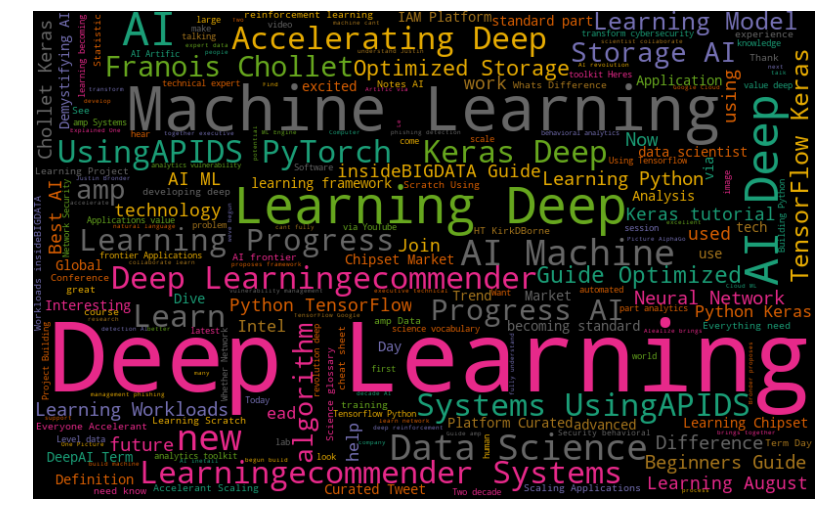

In [29]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

####  Most common words in negative tweets

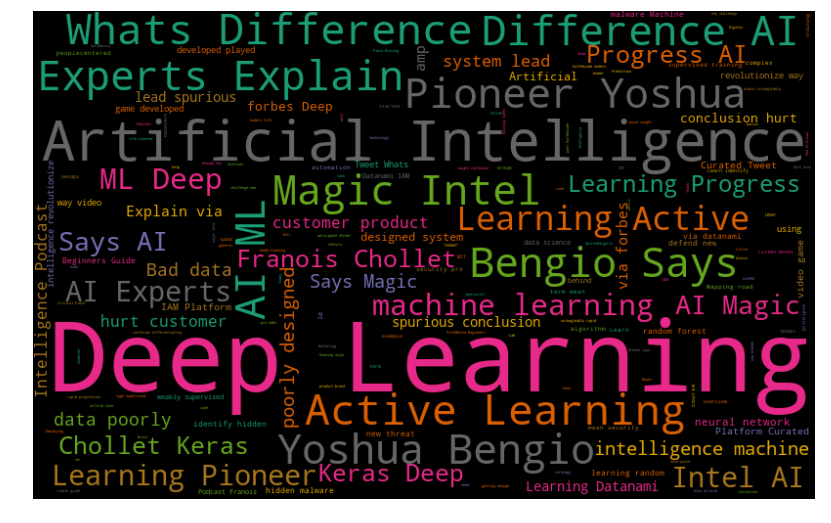

In [30]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'neg']])
generate_wordcloud(all_words)

- One thing to notice here is that word _'deep learning'_ has been used more than _'Machine Learning', 'AI', 'Artificial Intelligence', 'BigData'_ and _'DataScience'_, which shows the buzz of deep learning these days.

- AI, DeepLearning and MachineLearning have clearly been used in both positive and negative tweets, which is very obvious.
However, in negative tweets we can also see negative words as well like *stop, wrong, Unfortunately, fall, Cancer, shit, Greed, pressure, problem, complex, biased, never etc.*

####  Most commonly used Hashtags

In [31]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [32]:
hashtags = hashtag_extract(tweets_df['tidy_tweets'])
hashtags = sum(hashtags, [])

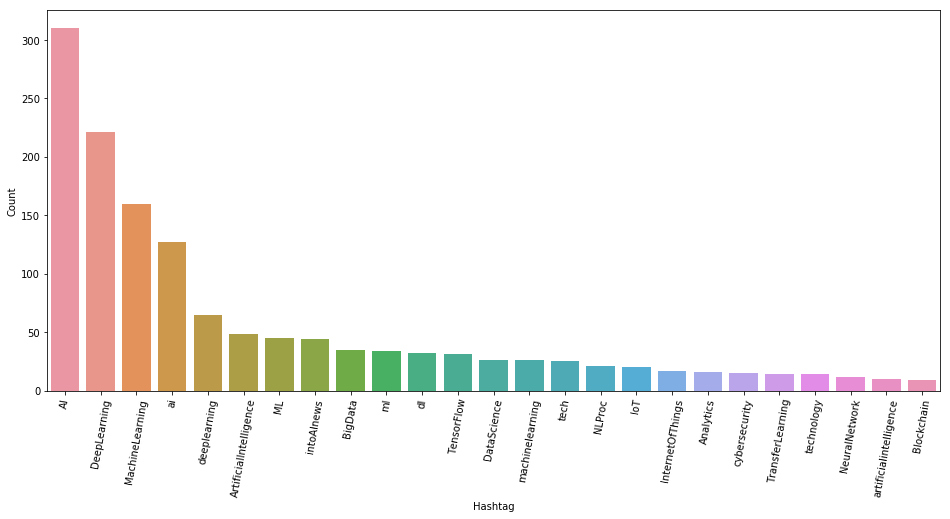

In [33]:
generate_hashtag_freqdist(hashtags)

As expected, AI, DeepLearning and MachineLearning are most common hashtags.

In [34]:
# For sake of consistency, we are going to discard the records which contains no phrases i.e where tweets_df['key_phrases'] contains []
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

##  Feature Extraction

We need to convert textual representation in the form on numeric features. We have two popular techniques to perform feature extraction:

1. __Bag of words (Simple vectorization)__
2. __TF-IDF (Term Frequency - Inverse Document Frequency)__

We will use extracted features from both one by one to perform sentiment analysis and will compare the result at last.


###  Feature Extraction for 'Key Words'

In [35]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

###  Feature Extraction for 'Key Phrases'

In [36]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

##  Model Building: Sentiment Analysis

#### Map target variables to  {0, 1}

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,auc
target_variable = tweets_df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [75]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.tab20c)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [76]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)
    
    fpr,tpr,thresh = roc_curve(y_test,predictions)

   # Plot ROC curve for Logistic Regression
    plt.plot(fpr,tpr,'green',label = 'RFClassifier with RFE')
    plt.legend("RFClassifier with RFE", loc='lower right')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc='lower right')

#plt.show()



###  Predictions on 'key words' based features

#### Bag Of Words (BOW) word features

Accuracy Score - 0.834070796460177


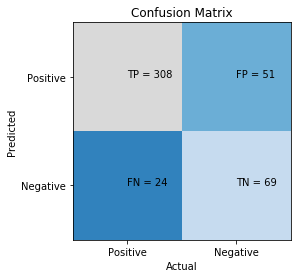

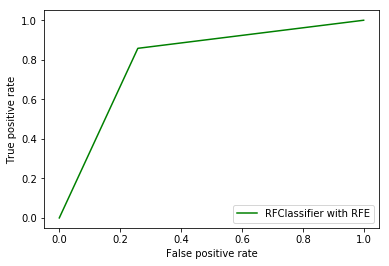

In [77]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

####  TF-IDF word features

Accuracy Score - 0.8407079646017699


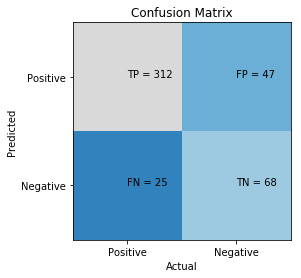

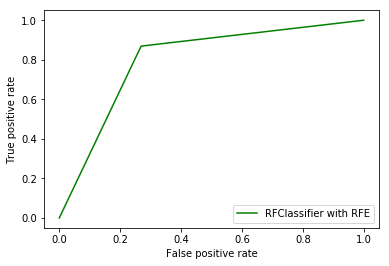

In [78]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

### Predictions on 'key phrases' based features

####  BOW Phrase features

Accuracy Score - 0.7654867256637168


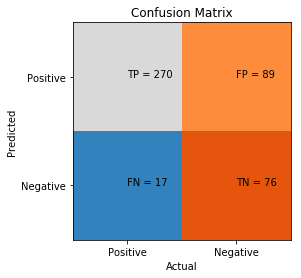

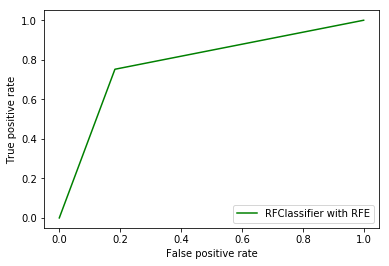

In [79]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

####  TF-IDF Phrase features

Accuracy Score - 0.7654867256637168


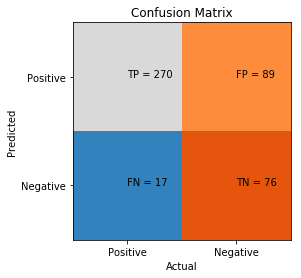

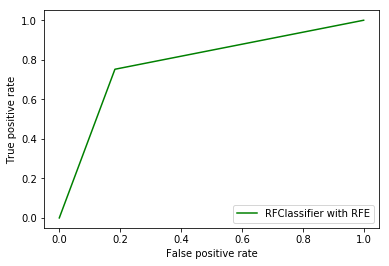

In [80]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Features extracted from 'key words' helps model in performing better. They have better positive predictions than the latter one. However, using 'key-phrase' based features improves the negative predictions.<br/><br/>

### Lgistic regression

####  Predictions on 'key words' based features

####  Bag Of Words (BOW) word features

In [81]:

from sklearn.linear_model import LogisticRegression
def logReg_model(X_train, X_test, y_train, y_test):
    logReg = LogisticRegression(random_state= 42, solver='lbfgs')
    logReg.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = logReg.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    print('Precision score  of LogisticRegression : ', format(precision_score(y_test, predictions)))
    print('Recall score  of LogisticRegression : ', format(recall_score(y_test, predictions)))
    print('F1 score  of LogisticRegression : ', format(f1_score(y_test, predictions)))
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)
    fpr,tpr,thresh = roc_curve(y_test,predictions)

   # Plot ROC curve for Logistic Regression
    plt.plot(fpr,tpr,'green',label = 'RFClassifier with RFE')
    plt.legend("RFClassifier with RFE", loc='lower right')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc='lower right')

#plt.show()




Accuracy Score - 0.9358407079646017
Precision score  of LogisticRegression :  0.9411764705882353
Recall score  of LogisticRegression :  0.9805013927576601
F1 score  of LogisticRegression :  0.9604365620736698


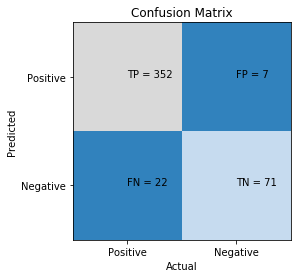

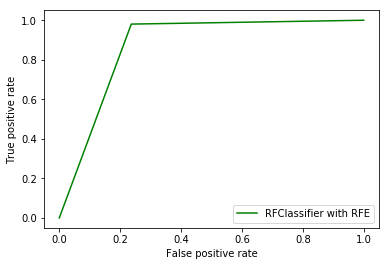

In [82]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
logReg_model(X_train, X_test, y_train, y_test)

####  TF-IDF word features


Accuracy Score - 0.9137168141592921
Precision score  of LogisticRegression :  0.9166666666666666
Recall score  of LogisticRegression :  0.9805013927576601
F1 score  of LogisticRegression :  0.9475100942126514


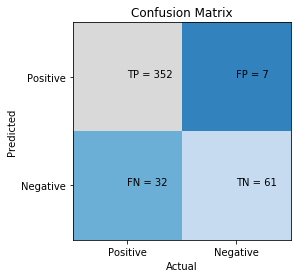

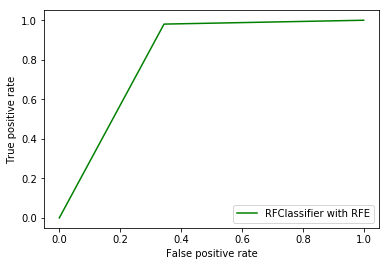

In [83]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
logReg_model(X_train, X_test, y_train, y_test)

####  BOW Phrase features

Accuracy Score - 0.9203539823008849
Precision score  of LogisticRegression :  0.9238845144356955
Recall score  of LogisticRegression :  0.9805013927576601
F1 score  of LogisticRegression :  0.9513513513513513


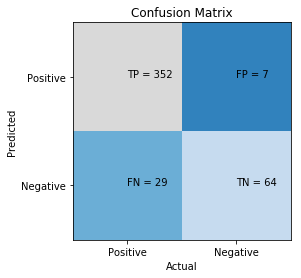

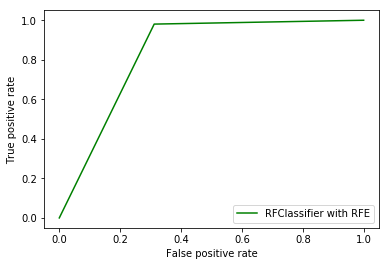

In [84]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
logReg_model(X_train, X_test, y_train, y_test)

####  TF-IDF Phrase features

Accuracy Score - 0.911504424778761
Precision score  of LogisticRegression :  0.9121447028423773
Recall score  of LogisticRegression :  0.9832869080779945
F1 score  of LogisticRegression :  0.9463806970509383


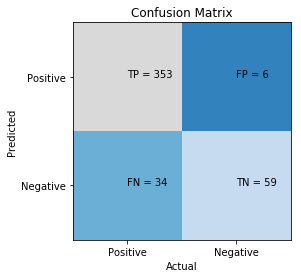

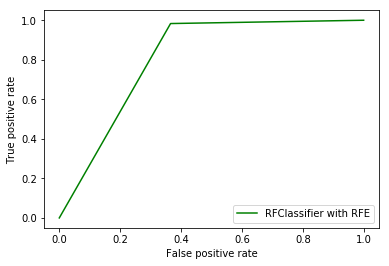

In [85]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
logReg_model(X_train, X_test, y_train, y_test)

## XGBoost Classifier

In [86]:
from xgboost import XGBClassifier
def xgbst_model(X_train, X_test, y_train, y_test):
    xgbst = XGBClassifier()
    xgbst.fit(X_train.toarray(), y_train)


    # predictions over test set
    predictions = xgbst.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    print('Precision score  of XGBoost : ', format(precision_score(y_test, predictions)))
    print('Recall score  of XGBoost : ', format(recall_score(y_test, predictions)))
    print('F1 score  of XGBoost : ', format(f1_score(y_test, predictions)))
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)
    fpr,tpr,thresh = roc_curve(y_test,predictions)

   # Plot ROC curve for Logistic Regression
    plt.plot(fpr,tpr,'green',label = 'RFClassifier with RFE')
    plt.legend("RFClassifier with RFE", loc='lower right')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc='lower right')

#plt.show()




Accuracy Score - 0.918141592920354
Precision score  of XGBoost :  0.9236842105263158
Recall score  of XGBoost :  0.9777158774373259
F1 score  of XGBoost :  0.9499323410013532


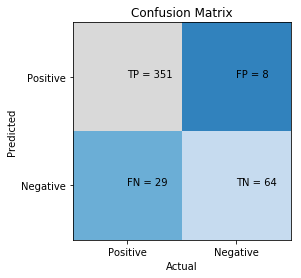

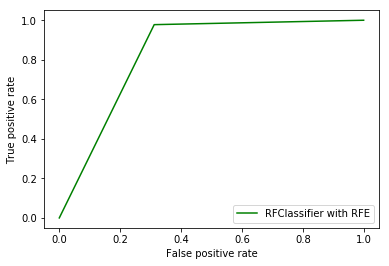

In [87]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
xgbst_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.9247787610619469
Precision score  of XGBoost :  0.9242819843342036
Recall score  of XGBoost :  0.9860724233983287
F1 score  of XGBoost :  0.954177897574124


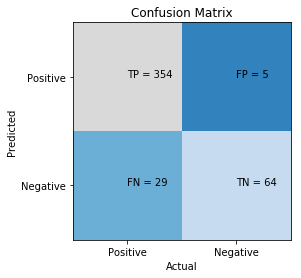

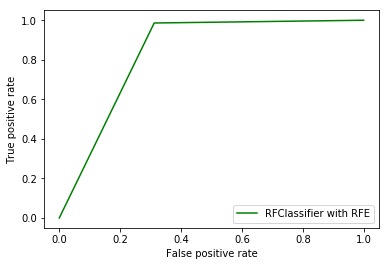

In [88]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
xgbst_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.915929203539823
Precision score  of XGBoost :  0.9190600522193212
Recall score  of XGBoost :  0.9805013927576601
F1 score  of XGBoost :  0.9487870619946092


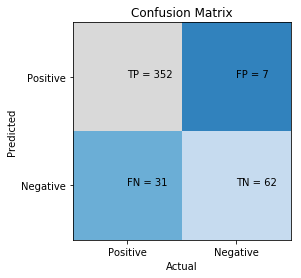

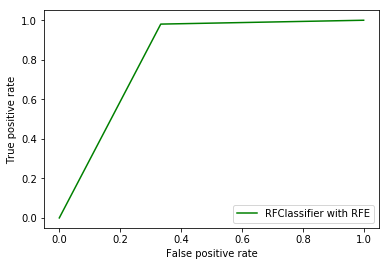

In [89]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
xgbst_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.9137168141592921
Precision score  of XGBoost :  0.9166666666666666
Recall score  of XGBoost :  0.9805013927576601
F1 score  of XGBoost :  0.9475100942126514


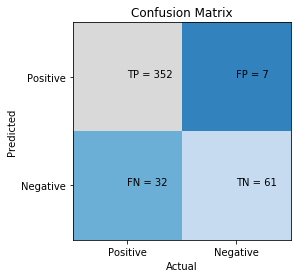

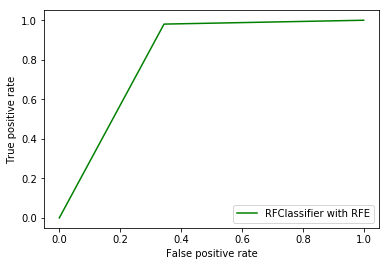

In [90]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
xgbst_model(X_train, X_test, y_train, y_test)

## Support Vector machine Classifier (SVM)/ linear model

In [91]:
from sklearn.svm import SVC
def svm_model(X_train, X_test, y_train, y_test):
    svm = SVC(kernel = "linear", C = 0.025)
    svm.fit(X_train.toarray(), y_train)


    # predictions over test set
    predictions = svm.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score of linear-SVM - {accuracy_score(y_test, predictions)}')
    print('Precision score of linear-SVM: ', format(precision_score(y_test, predictions)))
    print('Recall score of linear-SVM: ', format(recall_score(y_test, predictions)))
    print('F1 score of linear-SVM: ', format(f1_score(y_test, predictions)))
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)
    fpr,tpr,thresh = roc_curve(y_test,predictions)

   # Plot ROC curve for Logistic Regression
    plt.plot(fpr,tpr,'green',label = 'RFClassifier with RFE')
    plt.legend("RFClassifier with RFE", loc='lower right')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc='lower right')

#plt.show()




Accuracy Score of linear-SVM - 0.9203539823008849
Precision score of linear-SVM:  0.9238845144356955
Recall score of linear-SVM:  0.9805013927576601
F1 score of linear-SVM:  0.9513513513513513


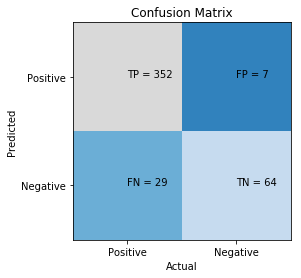

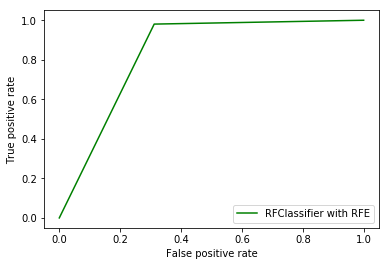

In [92]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
svm_model(X_train, X_test, y_train, y_test)

Accuracy Score of linear-SVM - 0.7942477876106194
Precision score of linear-SVM:  0.7942477876106194
Recall score of linear-SVM:  1.0
F1 score of linear-SVM:  0.8853267570900124


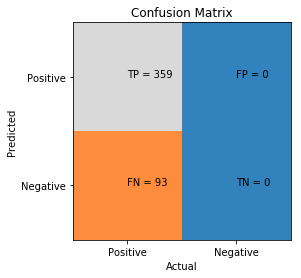

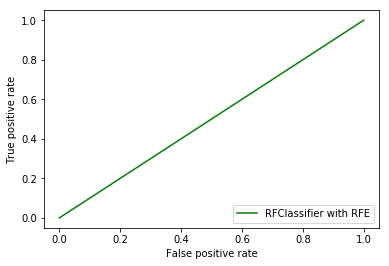

In [93]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
svm_model(X_train, X_test, y_train, y_test)

Accuracy Score of linear-SVM - 0.918141592920354
Precision score of linear-SVM:  0.9214659685863874
Recall score of linear-SVM:  0.9805013927576601
F1 score of linear-SVM:  0.9500674763832658


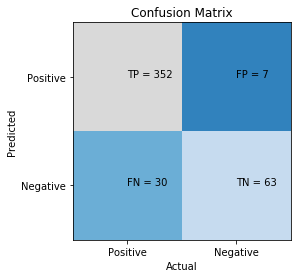

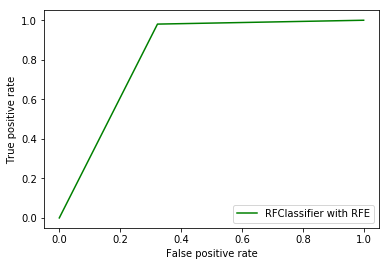

In [94]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
svm_model(X_train, X_test, y_train, y_test)

Accuracy Score of linear-SVM - 0.7942477876106194
Precision score of linear-SVM:  0.7942477876106194
Recall score of linear-SVM:  1.0
F1 score of linear-SVM:  0.8853267570900124


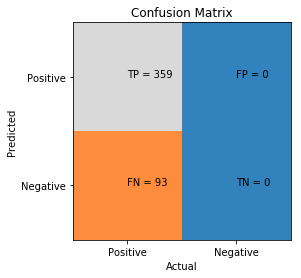

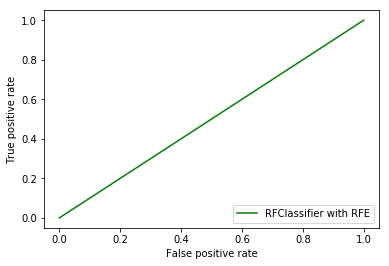

In [95]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
svm_model(X_train, X_test, y_train, y_test)

## Support Vector machine Classifier (SVM)/ polynomial model

In [96]:
def svm_p_model(X_train, X_test, y_train, y_test):
    svm_p = SVC(kernel = "poly", C = 0.5)
    svm_p.fit(X_train.toarray(), y_train)


    # predictions over test set
    predictions = svm_p.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score polynimial-SVM - {accuracy_score(y_test, predictions)}')
    print('Precision score of polynimial-SVM: ', format(precision_score(y_test, predictions)))
    print('Recall score of polynimial-SVM: ', format(recall_score(y_test, predictions)))
    print('F1 score of polynimial-SVM: ', format(f1_score(y_test, predictions)))
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)
    fpr,tpr,thresh = roc_curve(y_test,predictions)

   # Plot ROC curve for Logistic Regression
    plt.plot(fpr,tpr,'green',label = 'RFClassifier with RFE')
    plt.legend("RFClassifier with RFE", loc='lower right')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc='lower right')

#plt.show()




/Users/ilhamalami/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score polynimial-SVM - 0.7942477876106194
Precision score of polynimial-SVM:  0.7942477876106194
Recall score of polynimial-SVM:  1.0
F1 score of polynimial-SVM:  0.8853267570900124


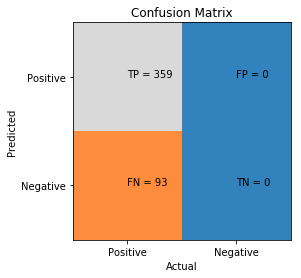

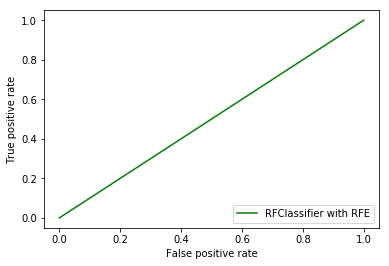

In [97]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
svm_p_model(X_train, X_test, y_train, y_test)

/Users/ilhamalami/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score polynimial-SVM - 0.7942477876106194
Precision score of polynimial-SVM:  0.7942477876106194
Recall score of polynimial-SVM:  1.0
F1 score of polynimial-SVM:  0.8853267570900124


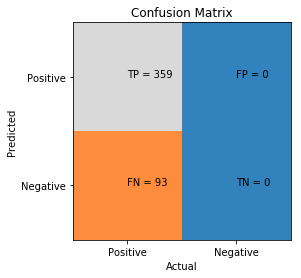

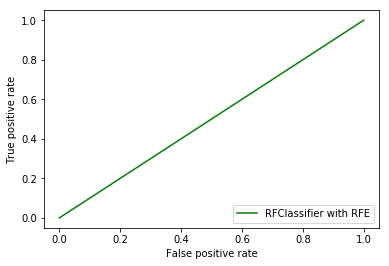

In [98]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
svm_p_model(X_train, X_test, y_train, y_test)

/Users/ilhamalami/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score polynimial-SVM - 0.7942477876106194
Precision score of polynimial-SVM:  0.7942477876106194
Recall score of polynimial-SVM:  1.0
F1 score of polynimial-SVM:  0.8853267570900124


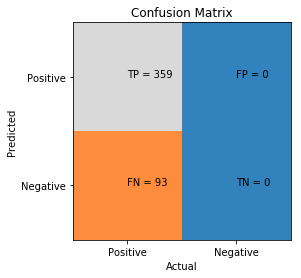

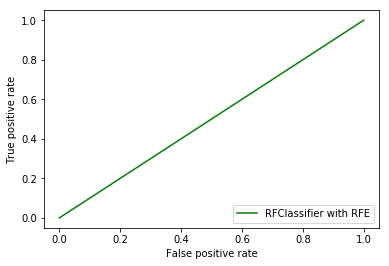

In [99]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
svm_p_model(X_train, X_test, y_train, y_test)

/Users/ilhamalami/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score polynimial-SVM - 0.7942477876106194
Precision score of polynimial-SVM:  0.7942477876106194
Recall score of polynimial-SVM:  1.0
F1 score of polynimial-SVM:  0.8853267570900124


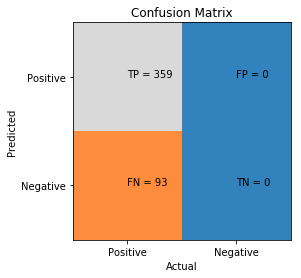

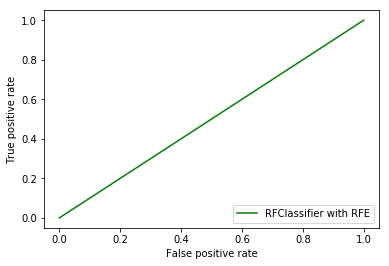

In [100]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
svm_p_model(X_train, X_test, y_train, y_test)

## Random Forest Classifier

In [101]:
from sklearn.ensemble import RandomForestClassifier
def rft_model(X_train, X_test, y_train, y_test):
    rft = RandomForestClassifier()
    rft.fit(X_train.toarray(), y_train)


    # predictions over test set
    predictions = rft.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score of RandomForestClassifier  - {accuracy_score(y_test, predictions)}')
    print('Precision score of RandomForestClassifier: ', format(precision_score(y_test, predictions)))
    print('Recall score of RandomForestClassifier: ', format(recall_score(y_test, predictions)))
    print('F1 score of RandomForestClassifier: ', format(f1_score(y_test, predictions)))
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)
    fpr,tpr,thresh = roc_curve(y_test,predictions)

   # Plot ROC curve for Logistic Regression
    plt.plot(fpr,tpr,'green',label = 'RFClassifier with RFE')
    plt.legend("RFClassifier with RFE", loc='lower right')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc='lower right')

#plt.show()




Accuracy Score of RandomForestClassifier  - 0.9336283185840708
Precision score of RandomForestClassifier:  0.94579945799458
Recall score of RandomForestClassifier:  0.9721448467966574
F1 score of RandomForestClassifier:  0.9587912087912087


/Users/ilhamalami/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


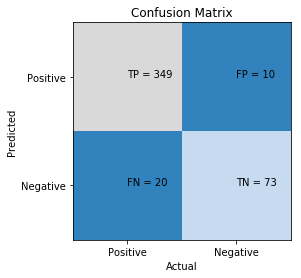

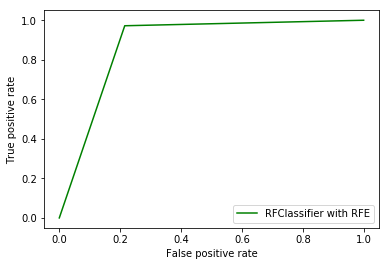

In [112]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
rft_model(X_train, X_test, y_train, y_test)

Accuracy Score of RandomForestClassifier  - 0.9314159292035398
Precision score of RandomForestClassifier:  0.9385026737967914
Recall score of RandomForestClassifier:  0.9777158774373259
F1 score of RandomForestClassifier:  0.9577080491132334


/Users/ilhamalami/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


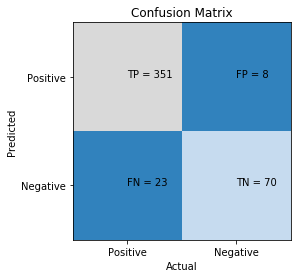

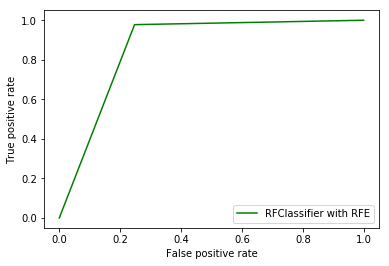

In [114]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
rft_model(X_train, X_test, y_train, y_test)

Accuracy Score of RandomForestClassifier  - 0.9314159292035398
Precision score of RandomForestClassifier:  0.9480874316939891
Recall score of RandomForestClassifier:  0.9665738161559888
F1 score of RandomForestClassifier:  0.9572413793103448


/Users/ilhamalami/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


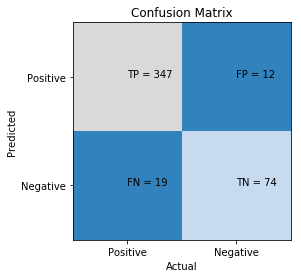

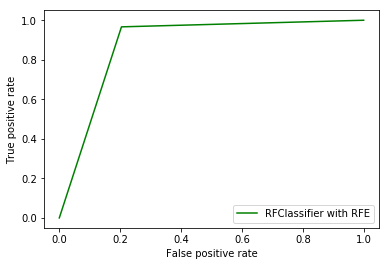

In [116]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
rft_model(X_train, X_test, y_train, y_test)

Accuracy Score of RandomForestClassifier  - 0.9314159292035398
Precision score of RandomForestClassifier:  0.9432432432432433
Recall score of RandomForestClassifier:  0.9721448467966574
F1 score of RandomForestClassifier:  0.9574759945130316


/Users/ilhamalami/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


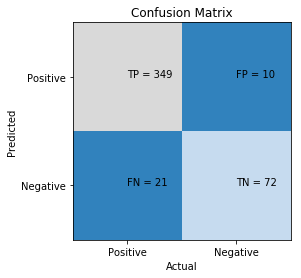

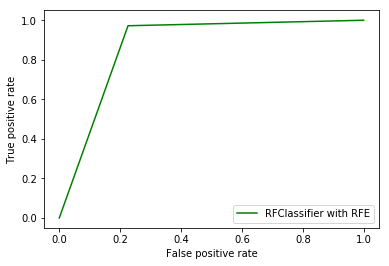

In [140]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
rft_model(X_train, X_test, y_train, y_test)

## AdaBoost Classifier (Boosting Ensemble Model)

In [141]:
from sklearn.ensemble import AdaBoostClassifier
def adaboost_model(X_train, X_test, y_train, y_test):
    adaboost = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)


    adaboost.fit(X_train.toarray(), y_train)


    # predictions over test set
    predictions = adaboost.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score of AdaBoostClassifier - {accuracy_score(y_test, predictions)}')
    print('Precision score of AdaBoostClassifier: ', format(precision_score(y_test, predictions)))
    print('Recall score of AdaBoostClassifier: ', format(recall_score(y_test, predictions)))
    print('F1 score of AdaBoostClassifier: ', format(f1_score(y_test, predictions)))
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)
    fpr,tpr,thresh = roc_curve(y_test,predictions)

   # Plot ROC curve for Logistic Regression
    plt.plot(fpr,tpr,'green',label = 'RFClassifier with RFE')
    plt.legend("RFClassifier with RFE", loc='lower right')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc='lower right')

#plt.show()




Accuracy Score of AdaBoostClassifier - 0.9247787610619469
Precision score of AdaBoostClassifier:  0.9380053908355795
Recall score of AdaBoostClassifier:  0.9693593314763231
F1 score of AdaBoostClassifier:  0.9534246575342467


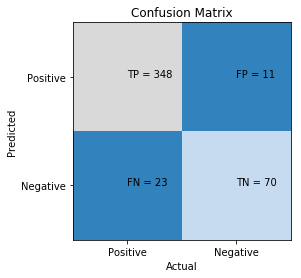

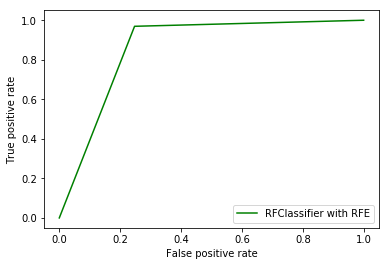

In [152]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
adaboost_model(X_train, X_test, y_train, y_test)

Accuracy Score of AdaBoostClassifier - 0.922566371681416
Precision score of AdaBoostClassifier:  0.9402173913043478
Recall score of AdaBoostClassifier:  0.9637883008356546
F1 score of AdaBoostClassifier:  0.951856946354883


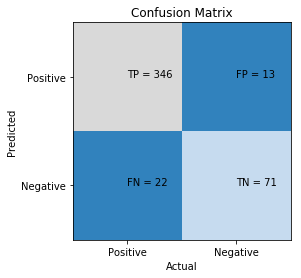

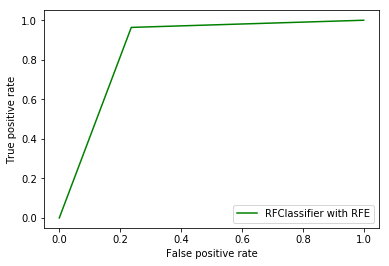

In [155]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
adaboost_model(X_train, X_test, y_train, y_test)

Accuracy Score of AdaBoostClassifier - 0.9247787610619469
Precision score of AdaBoostClassifier:  0.9333333333333333
Recall score of AdaBoostClassifier:  0.9749303621169917
F1 score of AdaBoostClassifier:  0.9536784741144414


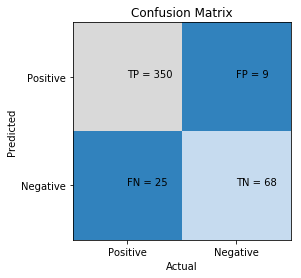

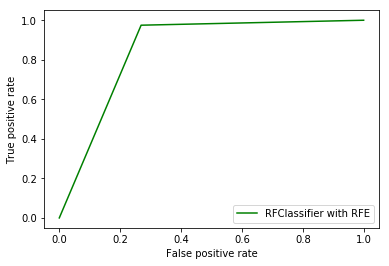

In [157]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
adaboost_model(X_train, X_test, y_train, y_test)

Accuracy Score of AdaBoostClassifier - 0.915929203539823
Precision score of AdaBoostClassifier:  0.9349593495934959
Recall score of AdaBoostClassifier:  0.9610027855153204
F1 score of AdaBoostClassifier:  0.9478021978021978


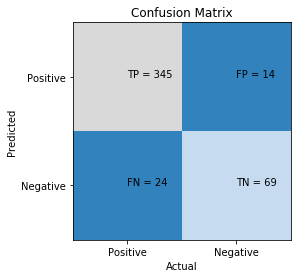

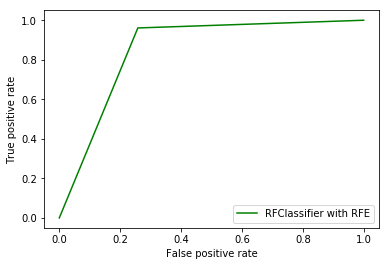

In [158]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
adaboost_model(X_train, X_test, y_train, y_test)

### Note: </br>
The more you train the models the higher accuracy you get</br>

Size of data depends on the fetched tweets and vary with time and topic

I get an accuracy up to 97.6% after parameters tuning

Recurrent Neural Network using LSTM reaches an accuracy of 99%
